In [0]:
import tensorflow as tf

class TFDeep:

    def __init__(self, neuron_count_list,
                 learning_rate=0.01,
                 param_lambda=1e-3,
                 hidden_function = tf.nn.relu, 
                 grad_optimizer = True,
                 fixed_step = True):
        """
        :param neuron_count_list: List containg neuron count.
            First element is dataset dimension.
            Last element(n-1) is class count.
        :param learning_rate: Rate of gradient descent.
        :param hidden_function:
            Tensorflow activation function used in the hidden layers.
        :param param_lambda: Regularization constant.
        """

        if len(neuron_count_list) < 2:
            raise Exception("Neuron count list must be at least 2 elements")

        data_dimension = neuron_count_list[0]
        class_count = neuron_count_list[-1]

        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        self.X = tf.placeholder(tf.float32, [None, data_dimension], name="X")
        self.Yoh_ = tf.placeholder(tf.float32, [None, class_count], name="Yoh_")

        self.W = []
        self.b = []
        self.H = []
        self.H.append(self.X)
        self.probs = None

        for i in range(1, len(neuron_count_list)):
            w_ = tf.Variable(
                    tf.random_normal(
                        [neuron_count_list[i-1], neuron_count_list[i]],
                        mean=0, stddev=1
                    ),
                    name = "W{}".format(i),
                    trainable = True
                )
            b_ = tf.Variable(
                    tf.random_normal(
                        [1, neuron_count_list[i]],
                        mean=0, stddev=1
                    ),
                    name = "b{}".format(i),
                    trainable=True
                )

            # OVDJE RADIM SA W MATRICOM KOJA JE TRANSPONIRANA !!
            # NIJE C x D nego D x C tako da ju nemoramo transponirat stalno(?)
            scores = tf.matmul(self.H[-1], w_) + b_

            # If it's the last one calculate probabilites
            if i == len(neuron_count_list)-1:
                scores_scaled = scores - tf.reduce_max(scores, axis=1)
                self.probs = tf.nn.softmax(scores)
            else:
                h_ = hidden_function(scores)
                self.H.append(h_)

            self.W.append(w_)
            self.b.append(b_)

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean

        # Get element - wise Yoh_ * self.probs - extract P(Y = yi | x = xi) in each row
        # Sum over each row so we get a vector
        correct_probs = tf.reduce_sum(tf.multiply(self.Yoh_, self.probs), axis=1)
        self.logprobs = tf.log(correct_probs)

        self.regulizer = 0
        for w_ in self.W:
            self.regulizer += tf.nn.l2_loss(w_)

        # Loss is mean of negative logprobs
        self.loss = tf.reduce_mean(- self.logprobs )\
            + param_lambda * self.regulizer

        if grad_optimizer:
            # formulacija operacije učenja: self.train_step
            #   koristiti: tf.train.GradientDescentOptimizer,
            #              tf.train.GradientDescentOptimizer.minimize
            self.trainer = tf.train.GradientDescentOptimizer(learning_rate)
            self.train_step = self.trainer.minimize(self.loss)
        else:
            
            if fixed_step:
                # Fixed step ADAM optimizer
                self.trainer = tf.train.AdamOptimizer(learning_rate)
                self.train_step = self.trainer.minimize(self.loss)
            else:
                # Decayed step ADAM optimizer
                self.global_step = tf.Variable(0, trainable=False)
                starter_learning_rate = learning_rate
                self.decayed_learning_rate = tf.train.exponential_decay(
                    starter_learning_rate, 
                    self.global_step, 
                    decay_steps=1,
                    decay_rate=1-1e-4)
                self.trainer = tf.train.AdamOptimizer(
                    self.decayed_learning_rate)
                self.train_step = self.trainer.minimize(self.loss)
        
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        self.tf_sess = tf.Session()

    def train(self, X, Yoh_, param_niter=1000, init_=True):
        """
        :param X: Dataset.
        :param Yoh_: Hot encoded labels.
        :param param_niter: Number of iteration.
        """
        
        if init_:
            # incijalizacija parametara
            #   koristiti: tf.initialize_all_variables
            self.tf_sess.run(tf.global_variables_initializer())

        # optimizacijska petlja
        #   koristiti: tf.Session.run
        for i in range(param_niter):
            _, loss, W, b = self.tf_sess.run \
                (
                    [self.train_step, self.loss, self.W, self.b],
                    feed_dict={self.X: X, self.Yoh_: Yoh_}
                )
            if i % 100 == 0:
                print("Iter: {}, loss: {}".format(i, loss))

        #print("W: ", W)
        #print("b: ", b)

        return W,b
    
    def train_mb(self, X, Yoh_, param_niter=1000, init_=True, batch_size=100):
        """
        Stochastic gradient descent.
        """
        if init_:
            # incijalizacija parametara
            #   koristiti: tf.initialize_all_variables
            self.tf_sess.run(tf.global_variables_initializer())
           
        #print(np.shape(X))
        # Total number of batches
        batch_count = np.shape(X)[0] // batch_size
        #print(batch_count)
        
        # Start iterations
        #print("Starting loop")
        for i in range(param_niter):
            
            loss = 0
            # shuffle 2 arrays at the same time
            s = np.arange(np.shape(X)[0])
            np.random.shuffle(s)
            X_shuffled = X[s]
            Y_shuffled = Yoh_[s]
            #print(np.shape(X_shuffled))
            #print(np.shape(X_shuffled))
              
            #print("Inside for1")
            # Go through all batch indices
            for batch_index in range(int(batch_count)):
                #print("Hello")
                batch_x = X_shuffled[
                    batch_index * batch_size : (batch_index + 1) * batch_size]
                batch_y = Y_shuffled[
                    batch_index * batch_size : (batch_index + 1) * batch_size]
                 
                #print(np.shape(batch_x))
                #print(np.shape(batch_y))
                # Train on current batch
                _, loss_, W, b = self.tf_sess.run \
                (
                    [self.train_step, self.loss, self.W, self.b],
                    feed_dict={self.X: batch_x, self.Yoh_: batch_y}
                )
                loss += loss_
            
            if i % 100 == 0:
                print("Iter: {}, loss:{}".format(i, loss/batch_count))
                
        
    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """

        y_pred = self.tf_sess.run([self.probs], feed_dict={self.X: X})
        return y_pred[0]

    def count_params(self):
        vars = tf.trainable_variables()
        print("Trainable variables:")
        total_params = 0
        for var in vars:
            print(var.name)
            shape_ = var.shape
            total_params += int(shape_[0]) * int(shape_[1])
        print("Parameter count: {}".format(total_params))
        
    def get_worst_data(self, X, Yoh_):
        """
        Returns data that contributes most to the loss function.
        """
        log_probs = self.tf_sess.run([self.logprobs], feed_dict={self.X: X, self.Yoh_:Yoh_})
        
        return log_probs

In [25]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np  

#tf.app.flags.DEFINE_string('data_dir',
#                         '/tmp/data/', 'Directory for storing data')

mnist = input_data.read_data_sets(
  '/tmp/data/', one_hot=True)
N = mnist.train.images.shape[0]
D = mnist.train.images.shape[1]
C = mnist.train.labels.shape[1]

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [5]:
# izgradi graf:
tf_deep = TFDeep([784,10],
                 learning_rate=0.05,
                 hidden_function=tf.nn.relu,
                 param_lambda=1e-3)

# nauči parametre:
W,b = tf_deep.train(
    mnist.train.images,
    mnist.train.labels,
    int(1e4))

Iter: 0, loss: 19.7642765045166
Iter: 100, loss: 9.920242309570312
Iter: 200, loss: 7.640639305114746
Iter: 300, loss: 6.559726238250732


KeyboardInterrupt: ignored

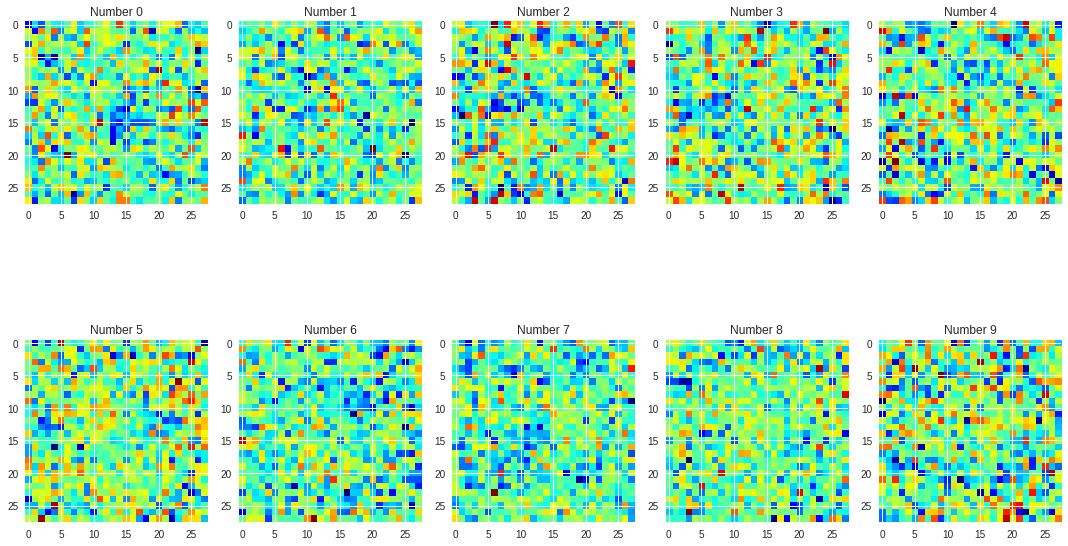

In [33]:
W_ = W[0]
plt.figure(figsize=(15,10))
# Plotting weights
for i in range(10):
  ax = plt.subplot(2,5 ,i+1)
  ax.imshow(W_[:,i].reshape(28,28), vmin=min(W_[:,i]), vmax=max(W_[:,i]), 
             cmap="jet")
  plt.title("Number {}".format(i))
plt.tight_layout()

In [66]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Accuracy for [784, 100]
predict = tf_deep.eval(mnist.test.images)
y_predict = np.argmax(predict, axis=1)
y_test_actual = [ np.where(r==1)[0][0] for r in mnist.test.labels ]
print("Accuracy for [784,100]: ", accuracy_score(y_predict, y_test_actual))
print("Confusion Matrix for [784, 100]:\n ",
      confusion_matrix(y_predict, y_test_actual))


Accuracy for [784,100]:  0.8955
Confusion Matrix for [784, 100]:
  [[ 942    0   11    5    1   18   16    3    4    9]
 [   2 1103   11    2    3    6    2   12   13    6]
 [   7    4  894   24    6   11   14   32    8    6]
 [   0    3   21  899    1   38    3    9   32   12]
 [   0    0   13    2  890   12   17    9   12   59]
 [  15    6    9   33    3  734   13    1   37    9]
 [  10    4   16    6   14   18  886    1   15    0]
 [   1    1   15   11    9   14    3  914    9   27]
 [   3   14   38   20   10   32    4    5  823   11]
 [   0    0    4    8   45    9    0   42   21  870]]


In [0]:
def deep_model(mnist, conf, learning_rate_=0.05, niter_=1e3, lambda_=1e-3):
    # izgradi graf:
    tf_deep = TFDeep(conf,
                     learning_rate=learning_rate_,
                     hidden_function=tf.nn.relu,
                     param_lambda=lambda_)
    
    # nauči parametre:
    tf_deep.train(
        mnist.train.images,
        mnist.train.labels,
        int(niter_))
    # Do the prediction
    predict = tf_deep.eval(mnist.test.images)
    y_predict = np.argmax(predict, axis=1)
    print("Conf: ", conf)
    print("Accuracy: ", accuracy_score(y_predict, y_test_actual))
    print("Confusion Matrix:\n ",
      confusion_matrix(y_predict, y_test_actual))
    return tf_deep

In [208]:
# NEEE PO KRE TA TI !!1
#dmodel_1 = deep_model(mnist, [784,10], lambda_=0)
dmodel_2 = deep_model(mnist, [784,100,10], learning_rate_=0.01, lambda_=0, niter_=1e3)
#dmodel_3 = deep_model(mnist, [784,100,100,10], lambda_=0, learning_rate_=0.005, niter_=1e4)
#dmodel_4 = deep_model(mnist, [784,100,100,100,10], lambda_=0, learning_rate_=0.005, niter_=1e4)

Iter: 0, loss: 11.117210388183594
Iter: 100, loss: 7.969705581665039
Iter: 200, loss: 6.5980658531188965
Iter: 300, loss: 5.66768741607666
Iter: 400, loss: 4.9867987632751465
Iter: 500, loss: 4.4695353507995605
Iter: 600, loss: 4.065537929534912
Iter: 700, loss: 3.741140365600586
Iter: 800, loss: 3.474735975265503
Iter: 900, loss: 3.25162935256958
Conf:  [784, 100, 10]
Accuracy:  0.5506
Confusion Matrix:
  [[694   3  27  35  23  59  60  22  45  17]
 [  5 917  59  13   8  29   8  20  50   5]
 [ 26  40 551  59  55  31  69  30  83  32]
 [ 58  37  91 510  39 133  33  21  91  33]
 [  5   6  29  20 460  56  44  37  60 194]
 [ 46  37  25 129  58 300  63  48 105  52]
 [ 83  20  78  43  30  58 600  18  53  15]
 [ 17   3  24  29  73  23   7 642  48 132]
 [ 25  59 122 155  75 124  49  42 365  62]
 [ 21  13  26  17 161  79  25 148  74 467]]


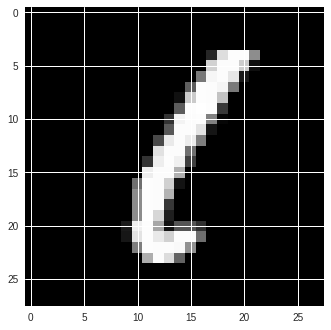

In [210]:
logprobs = dmodel_2.get_worst_data(mnist.test.images, mnist.test.labels)
index = np.argmin(logprobs)
plt.imshow(mnist.train.images[index,:].reshape(28, 28),
               cmap=plt.get_cmap('gray'),
               vmin=0, vmax=1)
plt.show()

In [34]:
# Early stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy

X_train, X_validate, Y_train, Y_validate = train_test_split(
        mnist.train.images, mnist.train.labels, test_size=1/5, random_state=42)

best_model = None
best_accuracy = -1
y_validate_actual = [ np.where(r==1)[0][0] for r in Y_validate ]

dVal = TFDeep([D, C], learning_rate=0.05, param_lambda=1e-4)
init_ = True
for i in range(1000):
    
    dVal.train_mb(
        X_train,
        Y_train,
        param_niter = int(100),
        batch_size = 5000,
        init_=init_)
    init_ = False # Disable initializing variables
    
    # Calculate accuracy
    validate_predict = dVal.eval(X_validate)
    y_validate_predict = np.argmax(validate_predict, axis=1)
    acc = accuracy_score(y_validate_predict, y_validate_actual)
    print("Current accuracy: ", acc)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = copy.copy(dVal)
        print("New best test accuracy: ", best_accuracy)
    else:
        print("Test accurarcy is worse. Stopping!")
        break

Iter: 0, loss:12.734777450561523
Current accuracy:  0.7073636363636364
New best test accuracy:  0.7073636363636364
Iter: 0, loss:1.8694589287042618
Current accuracy:  0.778
New best test accuracy:  0.778
Iter: 0, loss:1.426469773054123
Current accuracy:  0.8124545454545454
New best test accuracy:  0.8124545454545454
Iter: 0, loss:1.2446700483560562
Current accuracy:  0.8290909090909091
New best test accuracy:  0.8290909090909091
Iter: 0, loss:1.1413923501968384
Current accuracy:  0.84
New best test accuracy:  0.84
Iter: 0, loss:1.0612720847129822
Current accuracy:  0.847909090909091
New best test accuracy:  0.847909090909091
Iter: 0, loss:1.011048972606659
Current accuracy:  0.8544545454545455
New best test accuracy:  0.8544545454545455
Iter: 0, loss:0.9653805792331696
Current accuracy:  0.8590909090909091
New best test accuracy:  0.8590909090909091
Iter: 0, loss:0.9414305835962296
Current accuracy:  0.862
New best test accuracy:  0.862
Iter: 0, loss:0.9043601155281067
Current accuracy

Current accuracy:  0.8999090909090909
New best test accuracy:  0.8999090909090909
Iter: 0, loss:0.5720953047275543
Current accuracy:  0.8996363636363637
Test accurarcy is worse. Stopping!


Accuracy for [784,100]:  0.908
Confusion Matrix for [784, 100]:
  [[ 950    0    7    3    6   10   13    1   12    8]
 [   0 1105   11    0    2    2    4   11   14    5]
 [   3    2  908   24   10    4   10   26   13    1]
 [   3    3   18  905    4   42    1    7   31   10]
 [   0    0   12    2  895   10   14    5   13   34]
 [  10    4    7   28    0  762   18    2   32    7]
 [   9    3   15    4    7   17  890    0   10    0]
 [   3    2   13   13    7    8    5  938   12   35]
 [   2   15   38   23    9   33    3    4  827    9]
 [   0    1    3    8   42    4    0   34   10  900]]


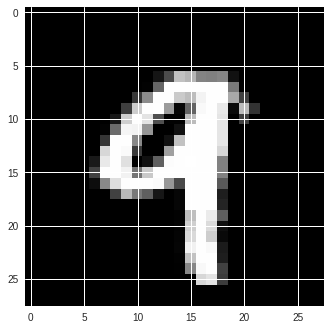

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Accuracy for [784, 100]
predict = best_model.eval(mnist.test.images)
y_predict = np.argmax(predict, axis=1)
y_test_actual = [ np.where(r==1)[0][0] for r in mnist.test.labels ]
print("Accuracy for [784,100]: ", accuracy_score(y_predict, y_test_actual))
print("Confusion Matrix for [784, 100]:\n ",
      confusion_matrix(y_predict, y_test_actual))

logprobs = best_model.get_worst_data(mnist.test.images, mnist.test.labels)
index = np.argmin(logprobs)
plt.imshow(mnist.train.images[index,:].reshape(28, 28),
               cmap=plt.get_cmap('gray'),
               vmin=0, vmax=1)
plt.show()

In [164]:
# Try doing batch
# izgradi graf:
tf_deep = TFDeep([784,100,10], # Best conf
                 learning_rate=0.001,
                 hidden_function=tf.nn.tanh,
                 param_lambda=0)

# nauči parametre:
tf_deep.train_mb(
    mnist.train.images,
    mnist.train.labels,
    param_niter = int(1e4),
    batch_size = 125)

# Do the prediction
predict = tf_deep.eval(mnist.test.images)
y_predict = np.argmax(predict, axis=1)
print("Conf: ", conf)
print("Accuracy: ", accuracy_score(y_predict, y_test_actual))
print("Confusion Matrix:\n ",
  confusion_matrix(y_predict, y_test_actual))

440
Iter: 0, loss:14.02718288898468


KeyboardInterrupt: ignored

In [154]:
# Try ADAM ??
# Try doing batch
# izgradi graf:
tf_deep = TFDeep([784,10], # Best conf
                 learning_rate=1e-4,
                 hidden_function=tf.nn.tanh,
                 param_lambda=1e-4,
                 grad_optimizer=False)

# nauči parametre:
tf_deep.train(
    mnist.train.images,
    mnist.train.labels,
    param_niter = int(1e4))

# Do the prediction
predict = tf_deep.eval(mnist.test.images)
y_predict = np.argmax(predict, axis=1)
print("Accuracy: ", accuracy_score(y_predict, y_test_actual))
print("Confusion Matrix:\n ",
  confusion_matrix(y_predict, y_test_actual))

Iter: 0, loss: 11.434654235839844
Iter: 100, loss: 10.643266677856445
Iter: 200, loss: 9.940604209899902
Iter: 300, loss: 9.316056251525879
Iter: 400, loss: 8.756917953491211
Iter: 500, loss: 8.25142765045166
Iter: 600, loss: 7.789986610412598
Iter: 700, loss: 7.365665912628174
Iter: 800, loss: 6.9736833572387695
Iter: 900, loss: 6.610625743865967
Iter: 1000, loss: 6.273977756500244
Iter: 1100, loss: 5.961757659912109
Iter: 1200, loss: 5.6722092628479
Iter: 1300, loss: 5.403646945953369
Iter: 1400, loss: 5.154426574707031
Iter: 1500, loss: 4.9229559898376465
Iter: 1600, loss: 4.7077202796936035
Iter: 1700, loss: 4.507328510284424
Iter: 1800, loss: 4.320542335510254
Iter: 1900, loss: 4.146262168884277
Iter: 2000, loss: 3.9834983348846436
Iter: 2100, loss: 3.8313493728637695
Iter: 2200, loss: 3.6889874935150146
Iter: 2300, loss: 3.555636167526245
Iter: 2400, loss: 3.4305660724639893
Iter: 2500, loss: 3.3130955696105957
Iter: 2600, loss: 3.2026002407073975
Iter: 2700, loss: 3.098514556884

Iter: 7300, loss: 1.1255980730056763
Iter: 7400, loss: 1.1080522537231445
Iter: 7500, loss: 1.0909582376480103
Iter: 7600, loss: 1.0742981433868408
Iter: 7700, loss: 1.058054804801941
Iter: 7800, loss: 1.0422121286392212
Iter: 7900, loss: 1.0267542600631714
Iter: 8000, loss: 1.0116665363311768
Iter: 8100, loss: 0.9969344139099121
Iter: 8200, loss: 0.9825441837310791
Iter: 8300, loss: 0.9684829711914062
Iter: 8400, loss: 0.9547388553619385
Iter: 8500, loss: 0.9413001537322998
Iter: 8600, loss: 0.9281563758850098
Iter: 8700, loss: 0.9152977466583252
Iter: 8800, loss: 0.9027150869369507
Iter: 8900, loss: 0.8903999328613281
Iter: 9000, loss: 0.8783442974090576
Iter: 9100, loss: 0.8665406703948975
Iter: 9200, loss: 0.8549823760986328
Iter: 9300, loss: 0.8436625003814697
Iter: 9400, loss: 0.8325748443603516
Iter: 9500, loss: 0.8217133283615112
Iter: 9600, loss: 0.8110724687576294
Iter: 9700, loss: 0.8006466627120972
Iter: 9800, loss: 0.7904305458068848
Iter: 9900, loss: 0.7804187536239624
Ac

In [138]:
X = mnist.train.images
s = np.arange(np.shape(X)[0])
s_s = np.random.shuffle(s)
print(s)
np.shape(X[s])

[40325 54304 16783 ... 14766 50234 27435]


(55000, 784)

In [159]:
# Try ADAM ??  -variable step
# Try doing batch
# izgradi graf:
tf_deep = TFDeep([784,10], # Best conf
                 learning_rate=1e-4,
                 hidden_function=tf.nn.relu,
                 param_lambda=1e-4,
                 grad_optimizer=False,
                 fixed_step=False)

# nauči parametre:
tf_deep.train(
    mnist.train.images,
    mnist.train.labels,
    param_niter = int(1e4))

# Do the prediction
predict = tf_deep.eval(mnist.test.images)
y_predict = np.argmax(predict, axis=1)
print("Accuracy: ", accuracy_score(y_predict, y_test_actual))
print("Confusion Matrix:\n ",
  confusion_matrix(y_predict, y_test_actual))

Iter: 0, loss: 16.07826042175293
Iter: 100, loss: 14.944221496582031
Iter: 200, loss: 13.947240829467773
Iter: 300, loss: 13.06700611114502
Iter: 400, loss: 12.281768798828125
Iter: 500, loss: 11.574572563171387
Iter: 600, loss: 10.932345390319824
Iter: 700, loss: 10.344440460205078
Iter: 800, loss: 9.802399635314941
Iter: 900, loss: 9.299647331237793
Iter: 1000, loss: 8.830942153930664
Iter: 1100, loss: 8.391968727111816
Iter: 1200, loss: 7.9793171882629395
Iter: 1300, loss: 7.590561389923096
Iter: 1400, loss: 7.223838806152344
Iter: 1500, loss: 6.877490043640137
Iter: 1600, loss: 6.550041198730469
Iter: 1700, loss: 6.240276336669922
Iter: 1800, loss: 5.947260856628418
Iter: 1900, loss: 5.6702375411987305
Iter: 2000, loss: 5.408560276031494
Iter: 2100, loss: 5.16166877746582
Iter: 2200, loss: 4.929065227508545
Iter: 2300, loss: 4.710277557373047
Iter: 2400, loss: 4.504815101623535
Iter: 2500, loss: 4.312148094177246
Iter: 2600, loss: 4.131685256958008
Iter: 2700, loss: 3.9627721309661

Iter: 7300, loss: 1.2288426160812378
Iter: 7400, loss: 1.2082760334014893
Iter: 7500, loss: 1.1882884502410889
Iter: 7600, loss: 1.1688545942306519
Iter: 7700, loss: 1.149951457977295
Iter: 7800, loss: 1.1315568685531616
Iter: 7900, loss: 1.1136500835418701
Iter: 8000, loss: 1.0962110757827759
Iter: 8100, loss: 1.0792216062545776
Iter: 8200, loss: 1.0626633167266846
Iter: 8300, loss: 1.0465195178985596
Iter: 8400, loss: 1.0307737588882446
Iter: 8500, loss: 1.0154105424880981
Iter: 8600, loss: 1.0004148483276367
Iter: 8700, loss: 0.9857724905014038
Iter: 8800, loss: 0.9714701771736145
Iter: 8900, loss: 0.9574951529502869
Iter: 9000, loss: 0.9438354969024658
Iter: 9100, loss: 0.9304801821708679
Iter: 9200, loss: 0.9174190759658813
Iter: 9300, loss: 0.9046424627304077
Iter: 9400, loss: 0.8921412229537964
Iter: 9500, loss: 0.8799068331718445
Iter: 9600, loss: 0.8679314851760864
Iter: 9700, loss: 0.856207549571991
Iter: 9800, loss: 0.844727635383606
Iter: 9900, loss: 0.8334850072860718
Accu

In [168]:
# One vs one SVM
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

# Linear model
y_actual_train = [ np.where(r==1)[0][0] for r in mnist.train.labels ]
linear_model = SVC(random_state=0, kernel='linear')
ovo_class = OneVsOneClassifier(linear_model)
ovo_class.fit(mnist.train.images, y_actual_train)
# Ovo predugo traje...
y_predict_linear = ovo_class.predict(mnist.test.images)


KeyboardInterrupt: ignored

In [211]:
kernel_model = SVC(random_state=0, kernel='rbf')
ovo_class = OneVsOneClassifier(kernel_model)
ovo_class.fit(mnist.train.images, y_actual_train)
kernel_predict = ovo_class.predict(mnist.test.images)

KeyboardInterrupt: ignored

In [162]:
np.shape(mnist.train.images)

(55000, 784)